In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
from scipy.stats import wilcoxon

In [2]:
#paths + global variables
subs = ['sub-01','sub-02', 'sub-03','sub-04', 'sub-05', 'sub-06']
ft_models = ['conv4', 'conv5', 'conv6', 'conv7', 'no']
atlas = ['wholebrain', 'STG']
baseline = 'no'

csv_path_sub236 = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/metrics.csv'
csv_path_sub145 = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/metrics_145.csv'
csv_path_leaderboard = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/leaderboard.csv'

In [3]:
df_236 = pd.read_csv(csv_path_sub236)
df_145 = pd.read_csv(csv_path_sub145)
HEAREVAL_leaderboard = pd.read_csv(csv_path_leaderboard)
HEAREVAL_leaderboard.pop('URL')
print(HEAREVAL_leaderboard)

                          Model   Beehive  Beijing Opera   CREMA-D  \
0       AMAAI Lab wav2vec2+DDSP       NaN       0.634929       NaN   
1   AMAAI wav2vec2 music+speech       NaN       0.826064  0.391367   
2                Sony UDONS ViT  0.877966       0.927926  0.440576   
3             CP-JKU PaSST 2lvl       NaN       0.965957  0.610381   
4         CP-JKU PaSST 2lvl+mel       NaN       0.965957  0.610381   
5             CP-JKU PaSST base       NaN       0.965957  0.610381   
6                         CREPE  0.593195       0.928103  0.382765   
7                   CVSSP PANNS  0.445747       0.911170  0.554986   
8        Descript/MARL Wav2CLIP  0.769796       0.936348  0.511564   
9                GURA Avg H+w+C       NaN       0.944770  0.547325   
10        GURA Avg Hubert+Crepe       NaN       0.932270  0.539662   
11     GURA Avg Hubert+wav2vec2       NaN       0.940514  0.699248   
12               GURA Cat H+w+C       NaN       0.936348  0.639419   
13     GURA Cat Hube

In [4]:
HEAREVAL_df = pd.concat([df_236,df_145], ignore_index=True)
HEAREVAL_df.sort_values(by=['subject', 'model'], inplace=True)
HEAREVAL_df.drop('Unnamed: 0', axis='columns', inplace=True)
models = HEAREVAL_df.pop('model')

In [5]:
eq = {
    'model':'Model',
    'beehive_states_fold0-v2-full_test_aucroc':'Beehive',
    'beehive_states_fold1-v2-full_test_aucroc':'Beehive_fold1',
    'beijing_opera-v1.0-hear2021-full_test_top1_acc_mean':'Beijing Opera',
    'beijing_opera-v1.0-hear2021-full_test_top1_acc_std':'Beijing Opera_std',
    'tfds_crema_d-1.0.0-full_test_top1_acc_mean':'CREMA-D',
    'tfds_crema_d-1.0.0-full_test_top1_acc_std':'CREMA-D_std',
    'dcase2016_task2-hear2021-full_test_event_onset_200ms_fms':'DCASE 2016',
    'esc50-v2.0.0-full_test_top1_acc_mean':'ESC-50',
    'esc50-v2.0.0-full_test_top1_acc_std':'ESC-50_std',
    'fsd50k-v1.0-full_test_mAP':'FSD50K',
    'tfds_gtzan-1.0.0-full_test_top1_acc_mean':'GTZAN Genre',
    'tfds_gtzan-1.0.0-full_test_top1_acc_std' : 'GTZAN Genre_std',    
    'tfds_gtzan_music_speech-1.0.0-full_test_top1_acc_mean':'GTZAN Music/Speech',
    'tfds_gtzan_music_speech-1.0.0-full_test_top1_acc_std' :'GTZAN Music/Speech_std',
    'gunshot_triangulation-v1.0-full_test_top1_acc_mean':'Gunshot',
    'gunshot_triangulation-v1.0-full_test_top1_acc_std':'Gunshot_std',
    'libricount-v1.0.0-hear2021-full_test_top1_acc_mean':'Libricount',
    'libricount-v1.0.0-hear2021-full_test_top1_acc_std':'Libricount_std',
    'maestro-v3.0.0-5h_test_event_onset_50ms_fms_mean':'Maestro 5h',
    'maestro-v3.0.0-5h_test_event_onset_50ms_fms_std':'Maestro 5h_std',
    'mridangam_stroke-v1.5-full_test_top1_acc_mean':'Mridangam Stroke',
    'mridangam_stroke-v1.5-full_test_top1_acc_std':'Mridangam Stroke_std',
    'mridangam_tonic-v1.5-full_test_top1_acc_mean':'Mridangam Tonic',
    'mridangam_tonic-v1.5-full_test_top1_acc_std':'Mridangam Tonic_std',
    'nsynth_pitch-v2.2.3-50h_test_pitch_acc':'NSynth Pitch 50h',
    'nsynth_pitch-v2.2.3-5h_test_pitch_acc':'NSynth Pitch 5h',
    'speech_commands-v0.0.2-5h_test_top1_acc':'Speech commands 5h',
    'speech_commands-v0.0.2-full_test_top1_acc':'Speech commands full',
    'vocal_imitation-v1.1.3-full_test_mAP_mean':'Vocal Imitation',
    'vocal_imitation-v1.1.3-full_test_mAP_std':'Vocal Imitation_std',
    'vox_lingua_top10-hear2021-full_test_top1_acc_mean':'VoxLingua107 top 10', 
    'vox_lingua_top10-hear2021-full_test_top1_acc_std':'VoxLingua107 top 10_std'
}

renamed_df = pd.concat([models, HEAREVAL_df], axis='columns')
renamed_df.rename(columns = eq, inplace=True)

In [6]:
all_df = pd.DataFrame()
for sub in subs:
    for a in atlas:
        selected_df = renamed_df.loc[(renamed_df['subject'] == sub) & (renamed_df['atlas'] == a)]
        for ft_model in ft_models:
            #conv
            diff_models = selected_df.loc[(selected_df['finetune'] == ft_model)]# | (selected_df['finetune'] == baseline)]
            merged_df = pd.merge(left=HEAREVAL_leaderboard, right=diff_models, how='outer')
            ranked_df = merged_df.rank(numeric_only=True, ascending=False)
            
            #baseline
            basl_models = selected_df.loc[(selected_df['finetune'] == baseline)]# | (selected_df['finetune'] == baseline)]
            merged_df2 = pd.merge(left=HEAREVAL_leaderboard, right=basl_models, how='outer')
            merged_df.loc[len(merged_df.index)] = merged_df2.iloc[-1]
            
            ranked_df2 = merged_df2.rank(numeric_only=True, ascending=False)
            ranked_df.loc[len(ranked_df.index)] = ranked_df2.iloc[-1]
            ranked_diff = ranked_df.diff(periods=-1).mul(-1)
            models_hp = merged_df[['Model', 'subject','atlas','finetune']]
            
            a = []
            for name, df in zip(('rank', 'diff_rank'), [ranked_df, ranked_diff]):
                all_hp_ranked_df = pd.concat([models_hp, df], axis='columns')
                models_ranks_df = all_hp_ranked_df.loc[all_hp_ranked_df['subject'].notna()]
                i_basl = models_ranks_df.index[models_ranks_df['finetune'] == baseline].tolist()
                models_ranks_df.drop(i_basl, axis = 0, inplace=True)
                models_melt = models_ranks_df.melt(id_vars= ['Model', 'subject','atlas','finetune'], 
                                               var_name = 'test', value_name = name, ignore_index=True)
                a.append(models_melt)
            sub_df = pd.merge(a[0], a[1], how = 'inner')   

            for i, row in sub_df.iterrows():
                if '_std' in str(row['test']) or '_fold1' in str(row['test']):
                    sub_df.drop(i, axis=0, inplace=True)
            
            all_df = pd.concat([all_df, sub_df], axis=0, ignore_index=True)

/home/maelle/virtualenv/visu/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
df = all_df.drop('Model', axis=1)
pd.set_option('display.max_rows', None)

print(df.loc[(df['finetune'] == 'conv7') & (df['atlas'] == 'wholebrain')].sort_values(['test', 'subject']))

    subject       atlas finetune                  test  rank  diff_rank
57   sub-01  wholebrain    conv7               Beehive   5.0        2.0
209  sub-02  wholebrain    conv7               Beehive   5.0       -0.0
361  sub-03  wholebrain    conv7               Beehive   5.0       -0.0
513  sub-04  wholebrain    conv7               Beehive   5.0       -0.0
665  sub-05  wholebrain    conv7               Beehive   5.0       -0.0
817  sub-06  wholebrain    conv7               Beehive   5.0       -0.0
58   sub-01  wholebrain    conv7         Beijing Opera  15.0       -5.0
210  sub-02  wholebrain    conv7         Beijing Opera  15.0       -0.0
362  sub-03  wholebrain    conv7         Beijing Opera  22.0        5.0
514  sub-04  wholebrain    conv7         Beijing Opera  17.0        2.0
666  sub-05  wholebrain    conv7         Beijing Opera  22.0        1.0
818  sub-06  wholebrain    conv7         Beijing Opera  22.0      -11.0
59   sub-01  wholebrain    conv7               CREMA-D  22.0    

<AxesSubplot:xlabel='subject', ylabel='test'>

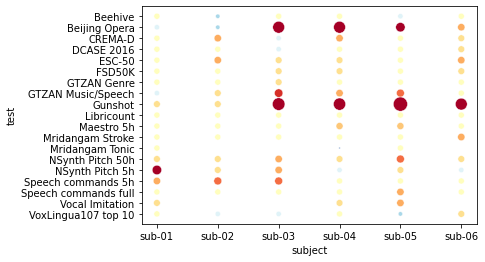

In [59]:
df_WB = df.loc[(df['finetune'] == 'conv4') & (df['atlas'] == 'wholebrain')].
test_order = ['Gunshot','Beijing Opera','NSynth Pitch 5h','NSynth Pitch 50h','ESC-50',
              'Speech commands 5h','CREMA-D','FSD50K','GTZAN Genre','GTZAN Music/Speech',
              'Speech commands full','Mridangam Stroke','Libricount','Maestro 5h',
              'Beehive','VoxLingua107 top 10','DCASE 2016','Vocal Imitation','Mridangam Tonic'
            ]

sns.scatterplot(data=df_WB, x="subject", y="test", 
                hue="diff_rank", size="diff_rank",sizes=(2, 200), hue_norm = (-5,5), palette = 'RdYlBu_r',
               legend=False, )

In [ ]:
for conv in ft_models:
    if conv == 'no' : 
        break
    for scale in atlas : 
        for sub in subs : 
            df_sub = df.loc[(df['finetune'] == conv) & (df['atlas'] == scale) & (df['subject'] == sub)]
            diff_values = df_sub['diff_rank'].values
            stat, pvalue = wilcoxon(diff_values)
            print(conv, scale, sub, pvalue, pvalue<0.05)
    print('')